# The effictiviness of measures to combat cellphone robery in the City of São Paulo

In [1]:
import pandas as pd
import os
import numpy as np

## Importing the data

In [2]:
stolen_cellphones = list()

for file in os.listdir("data"):
    stolen_cellphones.append(pd.read_excel(f"data/{file}").fillna(np.NaN))

In [3]:
stolen_cellphones_df = pd.concat(stolen_cellphones, axis=0)

## Data treatment

- Using the data description as support we can beging to filter ours columns. First we will identify the columns where we have less than half of non-NaN values, those will not be used, this could happend because of a change in the metodology in the collection of the report.
- We will also be droping where the columns about where the BO was registred, since the police that collected the BO is not responsible for investigating, only the precinct of the area that the crime happened. 
- We can also filter some variable that are identical in all of the observations. Like in the variable `DESCR_MODO_OBJETO`, where all the observation say that the object was stollen. The same thing happens in `DESCR_TIPO_OBJETO`,`DESCR_SUBTIPO_OBJETO`.
- Then we can filter all other observations that are not from São Paulo
- We can join the columns `DATA_OCORRENCIA_BO` and `HORA_OCORRENCIA` to get the precise time at which the crime happened, that also means we can drop the `MES` and `ANO` columns.

In [4]:
navalue_count = stolen_cellphones_df.notna().sum()
columns_to_drop = list(navalue_count[navalue_count < stolen_cellphones_df.shape[0]/2].index)
columns_to_drop


['TIPO_INTOLERANCIA',
 'DESDOBRAMENTO',
 'CIRCUNSTANCIA',
 'VERSAO',
 'FLAG_ATO_INFRACIONAL',
 'LOGRADOURO_VERSAO',
 'FLAG_BLOQUEIO',
 'FLAG_DESBLOQUEIO']

In [5]:
columns_BO_register = ['ID_DELEGACIA', 'NOME_DEPARTAMENTO', 'NOME_SECCIONAL', 
                       'NOME_DELEGACIA', 'NOME_MUNICIPIO', 'ANO_BO', 'NUM_BO', 
                       'DATAHORA_REGISTRO_BO', 'DATA_COMUNICACAO_BO', 'DATAHORA_IMPRESSAO_BO']
columns_redundant = ['DESCR_MODO_OBJETO', 'DESCR_TIPO_OBJETO', 'DESCR_SUBTIPO_OBJETO']
columns_to_drop += columns_BO_register + columns_redundant

In [6]:
stolen_cellphones_filtered = stolen_cellphones_df.drop(columns_to_drop, axis=1)
stolen_cellphones_filtered["CIDADE"] = stolen_cellphones_filtered["CIDADE"].str.strip()
stolen_cellphones_filtered = stolen_cellphones_filtered[stolen_cellphones_filtered["CIDADE"] == "S.PAULO"]

In [7]:
#stolen_cellphones_filtered[['DATA_OCORRENCIA_BO', 'HORA_OCORRENCIA']]
import re
tmp = []
for _, date in stolen_cellphones_filtered[['DATA_OCORRENCIA_BO', 'HORA_OCORRENCIA']].iterrows():
    try:
        date_str = re.search(r'\d{4}-\d{2}-\d{2}', str(date['DATA_OCORRENCIA_BO'])).group()
    except AttributeError:
        tmp.append("9999-99-99")
        continue
    try:
        hour = re.search(r'\d{2}:\d{2}:\d{2}', str(date['HORA_OCORRENCIA'])).group()
        tmp.append(date_str + ' ' + hour)
    except:
        tmp.append(date_str + ' ' + '00:00:00')
        continue

In [8]:
stolen_cellphones_filtered['DATA_OCORRENCIA'] = tmp
stolen_cellphones_filtered = stolen_cellphones_filtered[(stolen_cellphones_filtered['DATA_OCORRENCIA'] >= "2017") & (stolen_cellphones_filtered['DATA_OCORRENCIA'] < "2025")]
stolen_cellphones_filtered['DATA_OCORRENCIA'] = pd.to_datetime(stolen_cellphones_filtered['DATA_OCORRENCIA'], format="%Y-%m-%d %H:%M:%S")

## EDA (Exploratory Data Analysis)

1. The first thing we are gonna do is plot a heat map of the city across time to try to identify patterns and go from there.

In [9]:
import folium

In [10]:
sao_paulo_map = folium.Map([-23.587651, -46.663928], zoom_start=12)

In [11]:
lat_long_df = stolen_cellphones_filtered[['DATA_OCORRENCIA', 'LATITUDE', 'LONGITUDE']].round(5).dropna()

<Axes: xlabel='DATA_OCORRENCIA'>

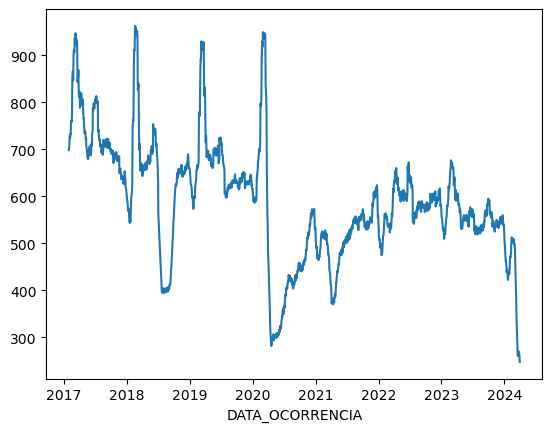

In [12]:
lat_long_df.groupby(lat_long_df["DATA_OCORRENCIA"].dt.date).size().rolling(window=30).mean().plot()

In [18]:
stolen_cellphones_df.to_parquet("STOLLEN_CELL_SP.pq")

ArrowInvalid: ("Could not convert 'AG4396' with type str: tried to convert to int64", 'Conversion failed for column NUM_BO with type object')

In [15]:
import pickle

In [16]:
with open("Stollen_cell.pkl", "rb") as file:
    h = pickle.load(file)